# Weight heterogeneity

In [1]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.9, 12)

np.set_printoptions(suppress=True, precision=2)

sns.set(font_scale=3.5)

from network import Protocol, NetworkManager, BCPNNPerfect
from plotting_functions import plot_weight_matrix, plot_state_variables_vs_time, plot_winning_pattern
from plotting_functions import plot_network_activity, plot_network_activity_angle
from analysis_functions import calculate_recall_time_quantities, calculate_angle_from_history, get_weights
from connectivity_functions import artificial_connectivity_matrix

## An example

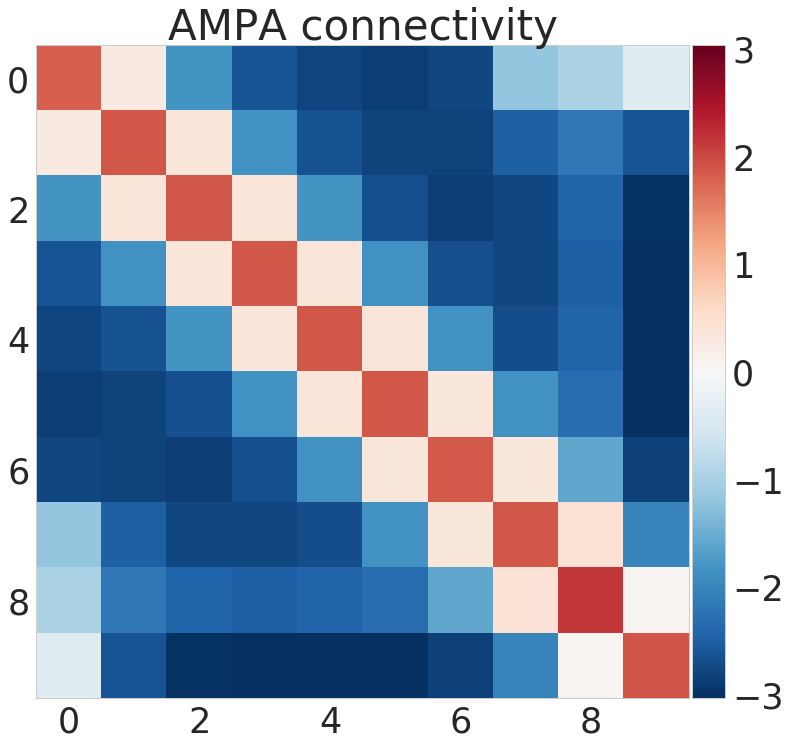

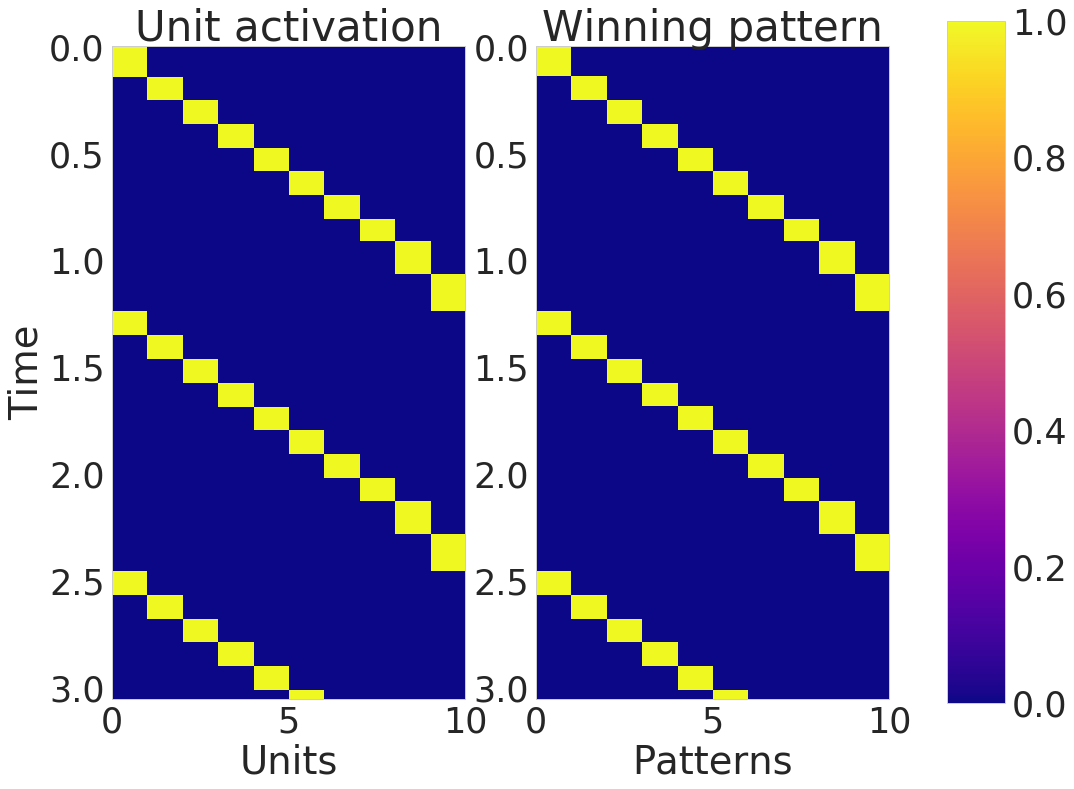

In [2]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

# Patterns parameters
hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.050
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 20

# Recall
T_recall = 3.0
n = 1
T_cue = 0.050


nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                  sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                  z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                  perfect=perfect, k_perfect=k_perfect, always_learning=always_learning)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the protocol for training
protocol = Protocol()
patterns_indexes = [i for i in range(n_patterns)]
protocol.simple_protocol(patterns_indexes, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                         inter_sequence_interval=inter_sequence_interval, epochs=epochs)

manager.run_network_protocol(protocol=protocol, verbose=False)
sequences = [patterns_indexes]
aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
total_sequence_time, mean, std, success, timings = aux

plot_weight_matrix(manager.nn, ampa=True)
plot_network_activity_angle(manager)

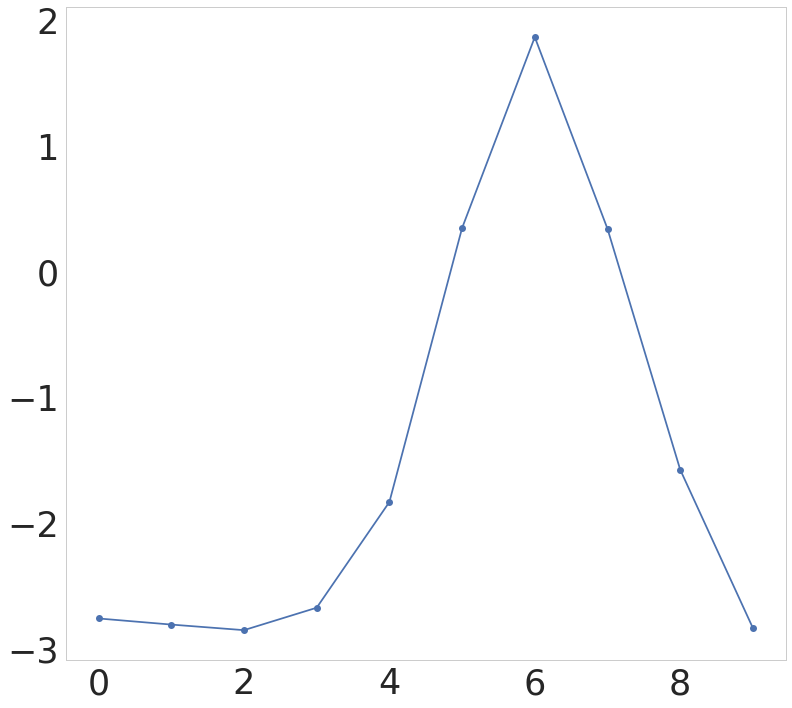

In [3]:
index = 6
indexes = [i for i in range(n_patterns) if i!=index]
plt.plot(nn.w_ampa[:, index], 'o-')
# plt.plot(nn.w_ampa[indexes, index], '*-');

## Tau_p 

In [4]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False

second_index = 1
last_index = n_patterns - 2

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

# Patterns parameters
hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
resting_time = inter_sequence_interval
epochs = 3

# Recall
T_recall = 3.0
n = 1
T_cue = 0.050

num = 25

tau_p_values = np.linspace(10, 100, num=num)

successes = np.zeros_like(tau_p_values)
persistent_times = np.zeros_like(tau_p_values)

index_to_store = 3
w_line = np.zeros((num, n_patterns - 1))


for index, tau_p in enumerate(tau_p_values):
    nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                      sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                      z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                      perfect=perfect, k_perfect=k_perfect, always_learning=always_learning)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    # Build the protocol for training
    protocol = Protocol()
    patterns_indexes = [i for i in range(n_patterns)]
    protocol.simple_protocol(patterns_indexes, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

    manager.run_network_protocol(protocol=protocol, verbose=False)
    sequences = [patterns_indexes]
    aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
    total_sequence_time, mean, std, success, timings = aux
    
    persistent_times[index] = mean
    successes[index] = success
    
    indexes = [i for i in range(n_patterns) if i!=index_to_store]
    w_line[index, :] = nn.w_ampa[indexes, index_to_store]

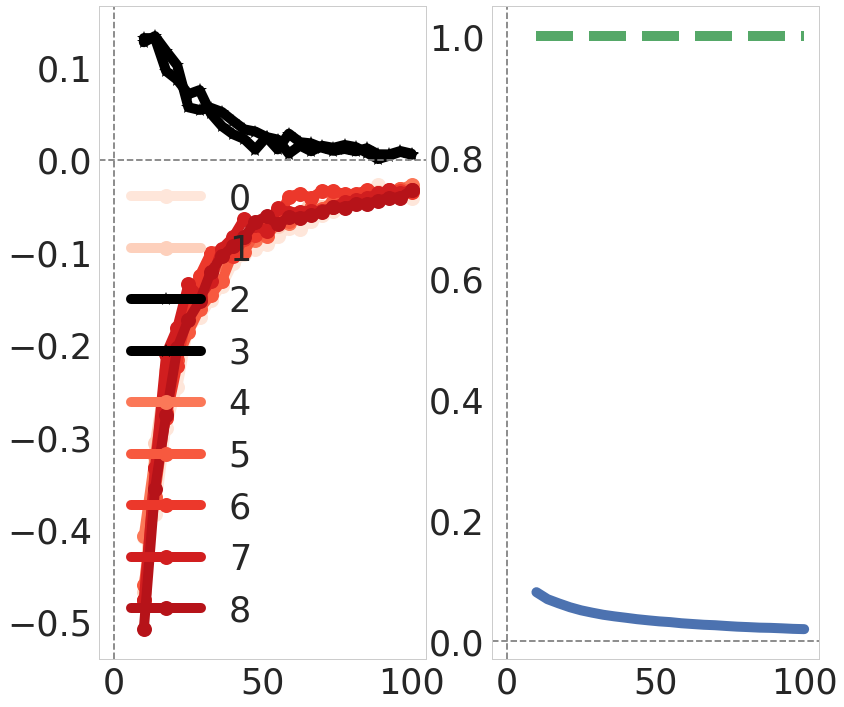

In [5]:
color_palette = sns.color_palette()
palette = sns.color_palette("Reds", n_patterns)


markersize = 15
linewidth = 10

fig = plt.figure()
ax1 = fig.add_subplot(121)

for index, line in enumerate(w_line.T):
    if index in [index_to_store, index_to_store - 1]:
        ax1.plot(tau_p_values, line, '*-', ms=markersize, lw=linewidth, color='black', label=str(index))
    else:
        ax1.plot(tau_p_values, line, 'o-', ms=markersize, lw=linewidth, color=palette[index], label=str(index))


ax1.axhline(0, ls='--', color='gray')
ax1.axvline(0, ls='--', color='gray')

ax1.legend()

ax2 = fig.add_subplot(122)
ax2.plot(tau_p_values, persistent_times, ms=markersize, lw=linewidth)
ax2.plot(tau_p_values, successes / 100.0, '--', ms=markersize, lw=linewidth)

ax2.axhline(0, ls='--', color='gray')
ax2.axvline(0, ls='--', color='gray');

## Training times

In [6]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False

second_index = 1
last_index = n_patterns - 2

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

# Patterns parameters
hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
resting_time = inter_sequence_interval
epochs = 3

# Recall
T_recall = 5.0
n = 1
T_cue = 0.050

num = 25

training_times = np.linspace(0.050, 1.0, num=num)

successes = np.zeros(num)
persistent_times = np.zeros(num)

index_to_store = 3
w_line = np.zeros((num, n_patterns - 1))


for index, training_time in enumerate(training_times):
    nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                      sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                      z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                      perfect=perfect, k_perfect=k_perfect, always_learning=always_learning)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    # Build the protocol for training
    protocol = Protocol()
    patterns_indexes = [i for i in range(n_patterns)]
    protocol.simple_protocol(patterns_indexes, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

    manager.run_network_protocol(protocol=protocol, verbose=False)
    sequences = [patterns_indexes]
    aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
    total_sequence_time, mean, std, success, timings = aux
    
    persistent_times[index] = mean
    successes[index] = success

    indexes = [i for i in range(n_patterns) if i!=index_to_store]
    w_line[index, :] = nn.w_ampa[indexes, index_to_store]

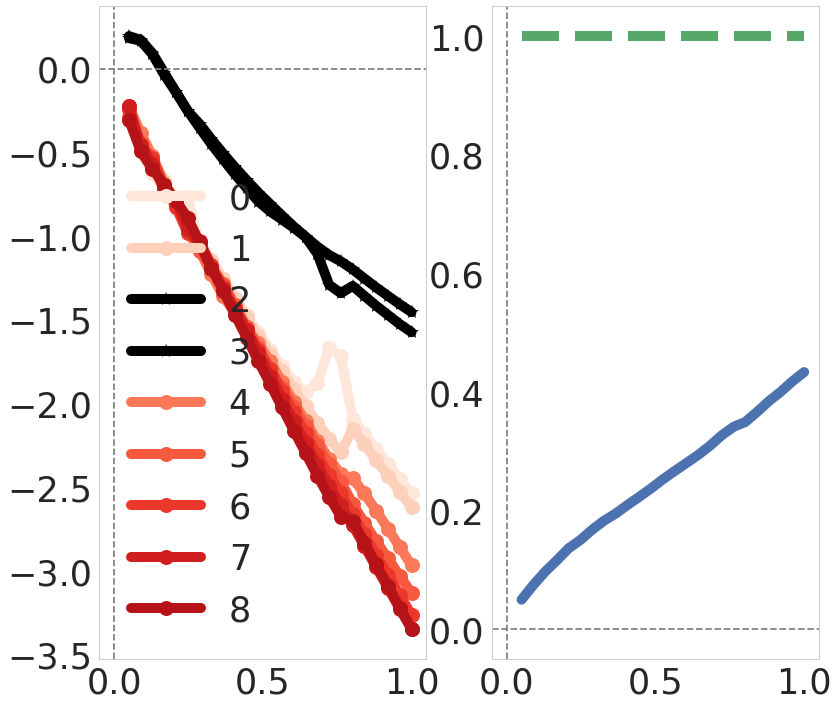

In [7]:
color_palette = sns.color_palette()
palette = sns.color_palette("Reds", n_patterns)


markersize = 15
linewidth = 10

fig = plt.figure()
ax1 = fig.add_subplot(121)

for index, line in enumerate(w_line.T):
    if index in [index_to_store, index_to_store - 1]:
        ax1.plot(training_times, line, '*-', ms=markersize, lw=linewidth, color='black', label=str(index))
    else:
        ax1.plot(training_times, line, 'o-', ms=markersize, lw=linewidth, color=palette[index], label=str(index))


ax1.axhline(0, ls='--', color='gray')
ax1.axvline(0, ls='--', color='gray')

ax1.legend()

ax2 = fig.add_subplot(122)
ax2.plot(training_times, persistent_times, ms=markersize, lw=linewidth)
ax2.plot(training_times, successes / 100.0, '--', ms=markersize, lw=linewidth)

ax2.axhline(0, ls='--', color='gray')
ax2.axvline(0, ls='--', color='gray');

## Tau_z

In [8]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

# Patterns parameters
hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
resting_time = inter_sequence_interval
epochs = 3

# Recall
T_recall = 3.0
n = 1
T_cue = 0.050

num = 25

tau_z_vector = np.linspace(0.005, 0.250, num=num)

successes = np.zeros(num)
persistent_times = np.zeros(num)

index_to_store = 3
w_line = np.zeros((num, n_patterns - 1))


for index, tau_z_pre_ampa in enumerate(tau_z_vector):
    nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                      sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_pre_ampa, tau_p=tau_p,
                      z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                      perfect=perfect, k_perfect=k_perfect, always_learning=always_learning)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    # Build the protocol for training
    protocol = Protocol()
    patterns_indexes = [i for i in range(n_patterns)]
    protocol.simple_protocol(patterns_indexes, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

    manager.run_network_protocol(protocol=protocol, verbose=False)
    sequences = [patterns_indexes]
    aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
    total_sequence_time, mean, std, success, timings = aux
    
    persistent_times[index] = mean
    successes[index] = success

    indexes = [i for i in range(n_patterns) if i!=index_to_store]
    w_line[index, :] = nn.w_ampa[indexes, index_to_store]

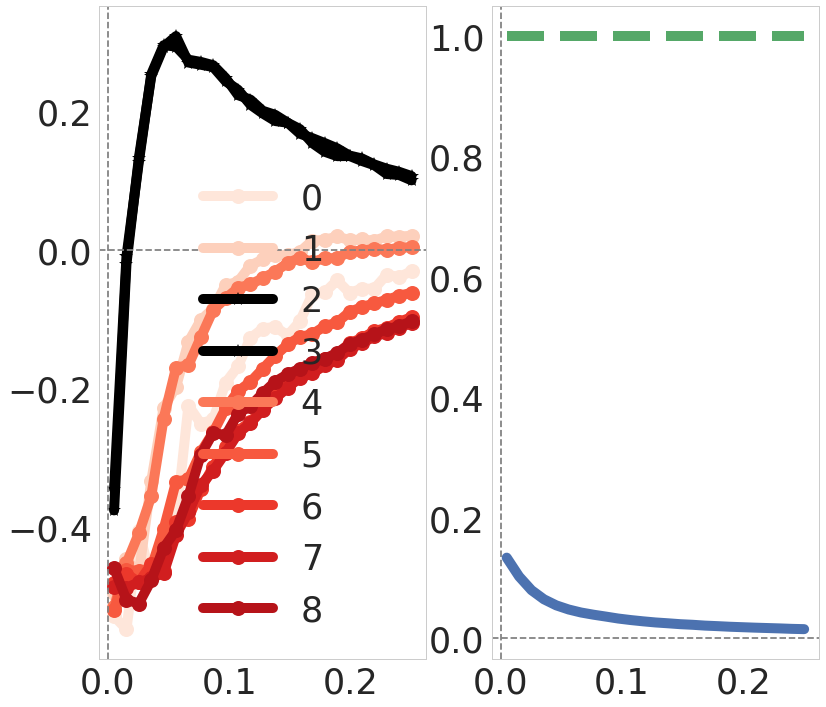

In [9]:
color_palette = sns.color_palette()
palette = sns.color_palette("Reds", n_patterns)


markersize = 15
linewidth = 10

fig = plt.figure()
ax1 = fig.add_subplot(121)

for index, line in enumerate(w_line.T):
    if index in [index_to_store, index_to_store - 1]:
        ax1.plot(tau_z_vector, line, '*-', ms=markersize, lw=linewidth, color='black', label=str(index))
    else:
        ax1.plot(tau_z_vector, line, 'o-', ms=markersize, lw=linewidth, color=palette[index], label=str(index))


ax1.axhline(0, ls='--', color='gray')
ax1.axvline(0, ls='--', color='gray')

ax1.legend()

ax2 = fig.add_subplot(122)
ax2.plot(tau_z_vector, persistent_times, ms=markersize, lw=linewidth)
ax2.plot(tau_z_vector, successes / 100.0, '--', ms=markersize, lw=linewidth)

ax2.axhline(0, ls='--', color='gray')
ax2.axvline(0, ls='--', color='gray');

## Epochs

In [10]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

# Patterns parameters
hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.050
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
resting_time = inter_sequence_interval
epochs = 3

# Recall
T_recall = 3.0
n = 1
T_cue = 0.050


epochs_vector = np.arange(1, 32, 2)
num = epochs_vector.size

successes = np.zeros(num)
persistent_times = np.zeros(num)

index_to_store = 3
w_line = np.zeros((num, n_patterns - 1))


for index, epochs in enumerate(epochs_vector):
    nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                      sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                      z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                      perfect=perfect, k_perfect=k_perfect, always_learning=always_learning)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    # Build the protocol for training
    protocol = Protocol()
    patterns_indexes = [i for i in range(n_patterns)]
    protocol.simple_protocol(patterns_indexes, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

    manager.run_network_protocol(protocol=protocol, verbose=False)
    sequences = [patterns_indexes]
    aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
    total_sequence_time, mean, std, success, timings = aux
    
    persistent_times[index] = mean
    successes[index] = success

    indexes = [i for i in range(n_patterns) if i!=index_to_store]
    w_line[index, :] = nn.w_ampa[indexes, index_to_store]

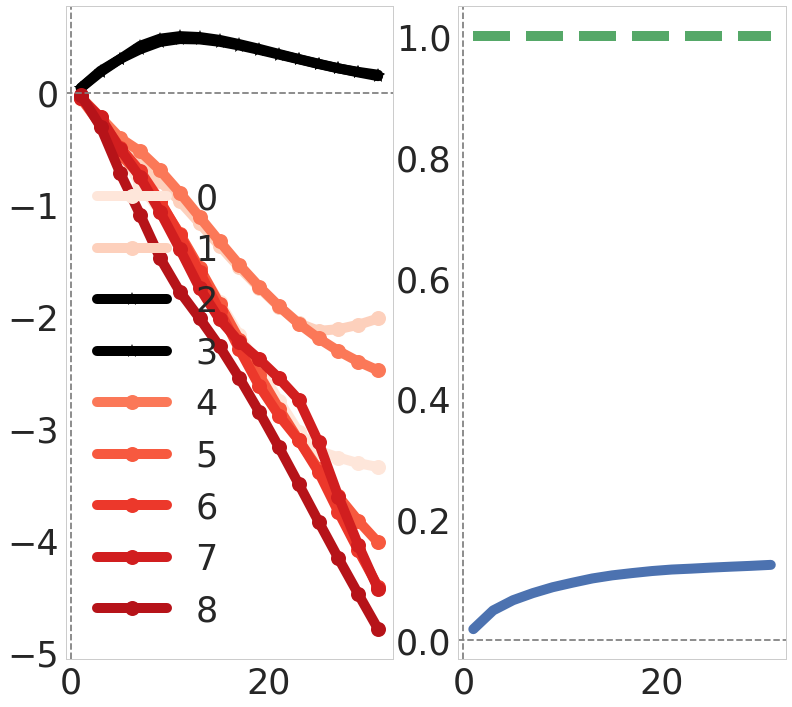

In [11]:
color_palette = sns.color_palette()
palette = sns.color_palette("Reds", n_patterns)


markersize = 15
linewidth = 10

fig = plt.figure()
ax1 = fig.add_subplot(121)

for index, line in enumerate(w_line.T):
    if index in [index_to_store, index_to_store - 1]:
        ax1.plot(epochs_vector, line, '*-', ms=markersize, lw=linewidth, color='black', label=str(index))
    else:
        ax1.plot(epochs_vector, line, 'o-', ms=markersize, lw=linewidth, color=palette[index], label=str(index))


ax1.axhline(0, ls='--', color='gray')
ax1.axvline(0, ls='--', color='gray')

ax1.legend()

ax2 = fig.add_subplot(122)
ax2.plot(epochs_vector, persistent_times, ms=markersize, lw=linewidth)
ax2.plot(epochs_vector, successes / 100.0, '--', ms=markersize, lw=linewidth)

ax2.axhline(0, ls='--', color='gray')
ax2.axvline(0, ls='--', color='gray');